In [1]:
import requests
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime as py_datetime
%matplotlib inline

In [2]:
#data=requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey=RU1K3VX6KM5GVHKJ")
#print("status code: ", data.status_code)

In [3]:
#jdata = json.loads(data.content)
#with open('alphavantage_series.txt', 'w') as ofile:
#    json.dump(jdata, ofile)
#    ofile.close()

In [4]:
with open('alphavantage_series.txt', 'r') as ifile:
    jdata1 = json.load(ifile)
    ifile.close()

In [8]:
#if data.status_code == 200: 
#jdata = json.loads(data.content)
meta_data = jdata1['Meta Data']
time_series_dict = jdata1['Time Series (Daily)'];
dates = list(time_series_dict.keys());

df = pd.DataFrame()
df['date'] = [pd.to_datetime(x) for x in dates]
df['open'] = [np.float64(time_series_dict[x]['1. open']) for x in dates]
df['high'] = [np.float64(time_series_dict[x]['2. high']) for x in dates]
df['low'] = [np.float64(time_series_dict[x]['3. low']) for x in dates]
df['close'] = [np.float64(time_series_dict[x]['4. close']) for x in dates]
df['volume'] = [np.float64(time_series_dict[x]['5. volume']) for x in dates]
df['symbol'] = meta_data['2. Symbol']
df.index = df['date']
#else:
 #   print("Error in retrieving data!, status code: ", data.status_code)


                 date   open   high   low  close      volume symbol
date                                                               
2018-04-26 2018-04-26  93.55  95.15  93.1  94.26  42529043.0   MSFT


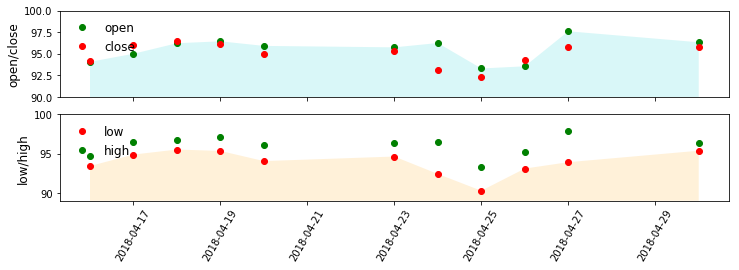

In [10]:
print(df['2018-04-26'])
fig, ax = plt.subplots(2,1, sharex='col')
fig.set_size_inches(12, 3.5)
ax[0].plot(df.index[0:11], df['open'][0:11], 'og')
ax[0].plot(df.index[0:11], df['close'][0:11], 'or')
ax[0].fill_between(df.index[0:11], 90, df['open'][0:11], facecolor='darkturquoise', alpha=0.15)
ax[0].set_ylim([90, 100])
ax[0].set_ylabel('open/close', fontsize=12)
ax[0].legend(['open', 'close'], frameon=0, fontsize=12, loc='upper left')

ax[1].plot(df.index[0:11], df['low'][0:11], 'or')
ax[1].plot(df.index[0:11], df['high'][0:11], 'og')
ax[1].fill_between(df.index[0:11], 89, df['low'][0:11], facecolor='orange', alpha=0.15)
ax[1].set_ylabel("low/high", fontsize=12)
ax[1].legend(['low', 'high'], frameon=0, fontsize=12, loc='upper left')
ax[1].set_ylim([89, 100])
ax[1].tick_params(axis='x', rotation=60)
plt.show()

In [11]:
print("Data Size in MB: {0}".format(df.memory_usage(index=True).sum()/1024/1024))

class tseries_data:
    def __init__(self, source, source_dates):
        self.dates = np.array(source_dates.map(str).tolist())
        self.dates = self.dates.flatten()
        self.tseries = source.as_matrix().flatten()
        self.nrow = self.tseries.shape
        self.nrow = self.nrow[0]
        
    def get_series(self, series_len, date_yes = False):
        if series_len > self.nrow:
            print("Requested series is longer than existing series")
            return
        else:
            begin = np.random.rand()
            begin = np.int(begin * (self.nrow - series_len - 1))
            x_temp = self.tseries[begin+1:begin+series_len+1]
            x = x_temp[::-1]
            y_temp = self.tseries[begin:begin+series_len]
            y = y_temp[::-1]
            date_series_temp = self.dates[begin:begin+series_len+1]
            date_series = date_series_temp[::-1]
            if date_yes:
                return np.reshape(x, [-1, series_len, 1]), np.reshape(y, [-1, series_len, 1]), np.reshape(date_series, [-1, series_len+1, 1])
            else:
                return np.reshape(x, [-1, series_len, 1]), np.reshape(y, [-1, series_len, 1]) 
        
    def get_latest_series(self, series_len, date_yes = False):
        if series_len > self.nrow:
            print("Requested series is longer than existing series")
            return
        else:
            x_temp = self.tseries[1:series_len+1]
            x = x_temp[::-1]
            y_temp = self.tseries[0:series_len]
            y = y_temp[::-1]
            date_series_temp = self.dates[0:series_len+1]
            date_series = date_series_temp[::-1]
        if date_yes:
            return np.reshape(x, [-1, series_len, 1]), np.reshape(y, [-1, series_len, 1]), np.reshape(date_series, [-1, series_len+1, 1])
        else:
            return np.reshape(x, [-1, series_len, 1]), np.reshape(y, [-1, series_len, 1])
        
    def get_batch(self, batch_size, series_len, date_yes = False):
        if series_len > self.nrow:
            print("Requested series is longer than existing series")
            return
        else:
            batch_x = np.zeros([series_len, batch_size])
            batch_y = np.zeros([series_len, batch_size])
            batch_date = np.empty([series_len+1, batch_size], dtype=np.object_)
            for ii in range(batch_size):
                x, y, d = self.get_series(series_len, 1)
                batch_x[:, ii], batch_y[:,ii], batch_date[:, ii] = x.flatten(), y.flatten(), d.flatten()
            if date_yes:   
                return np.reshape(batch_x, [-1, series_len, 1]), np.reshape(batch_y, [-1, series_len, 1]), np.reshape(batch_date, [-1, series_len+1, 1]) 
            else:
                return np.reshape(batch_x, [-1, series_len, 1]), np.reshape(batch_y, [-1, series_len, 1])        

Data Size in MB: 0.2813720703125


In [27]:
tsd = tseries_data(df['open'], df.index)
series_len = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1
learning_rate = 0.001
n_train_iter = 5000

In [28]:
tf.reset_default_graph()
xx = tf.placeholder(tf.float64, [None, series_len, n_inputs])
yy = tf.placeholder(tf.float64, [None, series_len, n_outputs])
cell = tf.contrib.rnn.OutputProjectionWrapper(
     tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.relu),
     output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, xx, dtype=tf.float64)
loss = tf.reduce_mean(tf.square(outputs - yy)) 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [29]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(n_train_iter):
        if iteration == n_train_iter - 1:
            x_series, y_series = tsd.get_latest_series(series_len)
        else:
            x_series, y_series = tsd.get_series(series_len)
        sess.run(train, feed_dict={xx: x_series, yy: y_series})
        
        if iteration % 100 == 0:            
            mse = loss.eval(feed_dict={xx: x_series, yy: y_series})
            print(iteration, "\t MSE Error:", mse)
    test_x, test_y, test_date = tsd.get_latest_series(series_len, True)
    y_pred = sess.run(outputs, feed_dict={xx: test_x})

0 	 MSE Error: 901.042017817
100 	 MSE Error: 259.521716398
200 	 MSE Error: 1253.5900008
300 	 MSE Error: 454.387424263
400 	 MSE Error: 412.864730802
500 	 MSE Error: 146.907888122
600 	 MSE Error: 225.004300525
700 	 MSE Error: 813.420502251
800 	 MSE Error: 110.314689492
900 	 MSE Error: 79.5623299312
1000 	 MSE Error: 240.637244885
1100 	 MSE Error: 1274.86038105
1200 	 MSE Error: 67.4666799448
1300 	 MSE Error: 176.660596136
1400 	 MSE Error: 31.3637426405
1500 	 MSE Error: 102.238622994
1600 	 MSE Error: 1125.75052609
1700 	 MSE Error: 26.0985741351
1800 	 MSE Error: 30.0387288862
1900 	 MSE Error: 32.988831479
2000 	 MSE Error: 266.424756022
2100 	 MSE Error: 223.498483657
2200 	 MSE Error: 93.9912813875
2300 	 MSE Error: 179.614879997
2400 	 MSE Error: 315.515852463
2500 	 MSE Error: 27.9500621666
2600 	 MSE Error: 374.42823734
2700 	 MSE Error: 47.200568822
2800 	 MSE Error: 263.417808787
2900 	 MSE Error: 22.1981691105
3000 	 MSE Error: 69.5185322819
3100 	 MSE Error: 20.479

(1, 50, 1)


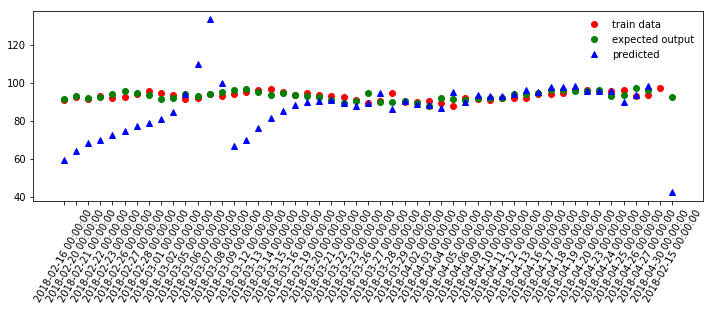

In [30]:
print(test_x.shape)
test_date = test_date.flatten()[::-1]
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 3.5)
ax.plot(test_date[0:-1], test_x.flatten()[::-1], 'or', label='train data')
ax.plot(test_date[1:], test_y.flatten()[::-1], 'og', label='expected output')
ax.plot(test_date[1:], y_pred.flatten()[::-1], '^b', label='predicted')
plt.legend(frameon=False)
ax.tick_params(axis='x', rotation=60)
plt.show()
